In [26]:
%matplotlib inline
from datetime import datetime, date, time
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import plotly as pl

train=pd.read_csv('TrainSample.csv',sep=';' )
test=pd.read_csv('TestSample.csv',sep=';' )
all=pd.concat([train,test])



In [2]:
ind=range(6,45)
ind.insert(0,1)
ind.insert(1,2)
names=[train.columns[i] for i in ind]


the above is just to collect the indexes of variables that are not:

API, any date, target

## Comparison of Variances

In [3]:
total_vars=[np.var(all[name]) for name in names]


In [4]:
train_vars=[[name,np.var(train[name])] for name in names]# test does not have oil and gas
pd.DataFrame(train_vars).sort_values(1).head()


,0,1
13,Res_PPLS (Ohmm),0.486012
29,Max_Treating_pressure (KPa),0.560473
38,Shot_Total,0.633596
22,Zone,0.882459
3,Depth_TVD_PPLS (ft),0.896236


In [5]:
pd.DataFrame(train_vars).sort_values(1).tail()

,0,1
21,Heat_Flow (W/m2),1.161726
30,Min_Treating_Pressure (KPa),1.170414
18,Temp_Anomaly (F),1.187651
14,GR_PPLS (API),1.371725
24,Frac_Gradient (PSI/ft),1.651402


The varicane of the **training** set varibales is between 0.48 and 1.65

The varicane of the **testing**  set varibales is between 0.05 and 1.31   (not shown)

We want to compare the variances between training and testing now.
For that, we do for each variable:

|train var - test var| / total variance

In [6]:
test_vars=[[name,np.var(test[name])] for name in names]# test does not have oil and gas


vars_difference=[ [test_vars[i][0], np.abs(test_vars[i][1]- train_vars[i][1])/total_vars[i]]for i in range(len(train_vars))]
vars_difference=pd.DataFrame(vars_difference)
vars_difference=vars_difference.sort_values(1,ascending=False)
vars_difference.columns=('Variable','Normalized Difference of Variance Train and Test')
vars_difference.head(9)

,Variable,Normalized Difference of Variance Train and Test
24,Frac_Gradient (PSI/ft),1.457933
13,Res_PPLS (Ohmm),0.987909
29,Max_Treating_pressure (KPa),0.920878
14,GR_PPLS (API),0.687765
30,Min_Treating_Pressure (KPa),0.377846
10,PR_PPLS,0.337004
18,Temp_Anomaly (F),0.321516
33,Min_Rate_Slurry (bpm),0.319925
36,ISIP (KPa),0.297417


So we actually have a significant differene in the variance between train and test in some variables. That's also a difficulty for anova..

## Comparision of the means 
We calculate the mean for each varible and compare train set with test set, normalized by the standard deviation.

In [7]:
train_means=[[name,np.mean(train[name])] for name in names]# test does not have oil and gas


test_means=[[name,np.mean(test[name])] for name in names]# test does not have oil and gas

means_difference=[ [test_means[i][0], np.abs(test_means[i][1]- train_means[i][1])/np.sqrt(total_vars[i])] for i in range(len(train_means))]
means_difference=pd.DataFrame(means_difference)
means_difference.columns=['variable','normalized means difference']
means_difference.sort_values('normalized means difference',ascending=False).head()

,variable,normalized means difference
37,Shot_Density (shots/ft),0.288735
34,ShutInPressure_Fil (KPa),0.230996
33,Min_Rate_Slurry (bpm),0.194738
38,Shot_Total,0.183145
31,Avg_Rate_Slurry (bpm),0.164338


The highest difference in means has Shot_Density. So we are gonna make a histogram.

In [8]:

#plt.figure(figsize=(8,8))

#plt.scatter(train[train.columns[n]],train[train.columns[n+1]],c='blue',label='train',s=15)
#plt.scatter(test[test.columns[n]],test[test.columns[n+1]],c='red',label='test',s=10)
#plt.xlabel(train.columns[n])
#plt.ylabel(train.columns[n+1])
#plt.legend()

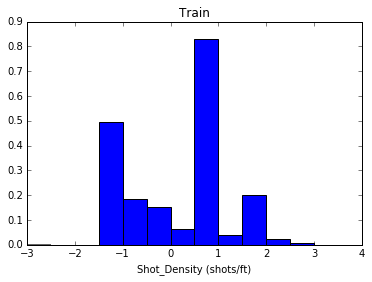

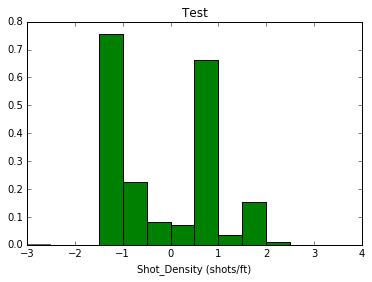

In [23]:
bins2=np.arange(-3,4,0.5)
plt.hist(train.dropna()['Shot_Density (shots/ft)'],bins=bins2,normed=True)
plt.xlabel('Shot_Density (shots/ft)')
plt.title('Train')
plt.figure()

plt.hist(test.dropna()['Shot_Density (shots/ft)'],bins=bins2,normed=True,color='g')
plt.xlabel('Shot_Density (shots/ft)')
plt.title('Test')

It looks like ShotDensity has two main means.
The difference is noticable, but is it significant ?

Let do a statistical test.

 ## Equal means test ( Mann-Whitney U test)

In [27]:
mwTests=[(sp.stats.mannwhitneyu(train[name],test[name]).pvalue,name) for name in names]
mwTests=pd.DataFrame(mwTests)
mwTests.columns=('p-value','variable')
mwTests=mwTests.sort_values('p-value')
mwTests[:10]        

,p-value,variable
37,0.003324,Shot_Density (shots/ft)
14,0.010650,GR_PPLS (API)
34,0.026278,ShutInPressure_Fil (KPa)
36,0.127562,ISIP (KPa)
1,0.177830,Surf_Y
25,0.187393,Proppant_Designed (kg)
26,0.188806,Proppant_in_Formation (kg)
28,0.193210,Avg_Treating_Pressure (KPa)
33,0.201117,Min_Rate_Slurry (bpm)
29,0.203307,Max_Treating_pressure (KPa)


**Shot density** has the highest probability, that the means of train and test are not equal.
Candidates for not equal means are also: **GR_PPLS (API),ShutInPressure_Fil (KPa).**

## KS Test for Equality of distributions

In [17]:
ksTests=[(sp.stats.ks_2samp(train[name],test[name]).pvalue,name) for name in names]
ksTests=pd.DataFrame(ksTests)
ksTests.columns=('p-value','variable')
ksTests=ksTests.sort_values('p-value')
ksTests[:10]                                                                  

,p-value,variable
37,0.001678,Shot_Density (shots/ft)
26,0.032129,Proppant_in_Formation (kg)
34,0.044326,ShutInPressure_Fil (KPa)
2,0.054308,Lateral_Length (ft)
14,0.059435,GR_PPLS (API)
25,0.060360,Proppant_Designed (kg)
23,0.073545,Nbr_Stages
33,0.107922,Min_Rate_Slurry (bpm)
31,0.110066,Avg_Rate_Slurry (bpm)
38,0.118013,Shot_Total


With risk of alpha = 0.05 we have to throw the null hypothesis of equality of distributions for 3 festures.
**Shot_Density   Proppant_in_Formation (kg) ShutInPressure_Fil (KPa)**

 ## Test for normality
 If we have normality in certain features, the test of equals means in train and test in each variable could be more accurate... so we check each variable in train and test for normality..

In [ ]:

norm_test_train=[sp.stats.kstest((train.dropna()[name]-np.mean(train.dropna()[name]))/np.sqrt(np.var(train.dropna()[name])),'norm') for name in names]

norm_test_train=pd.DataFrame(norm_test_train)
norm_test_train.sort_values('pvalue').tail(15)

the majority of the feature can no be considered normally distributed. The tail above just shows the features with high p-value. ( those that are most likely to be normally distributed)